# Robust Single Linkage

In [1]:
import numpy as np
import networkx as nx # For easily getting connected components!

In [2]:
data = np.array([0, 1, 3, 6, 10, 15])

k = 2
alpha = 0.5

In [3]:
def get_distances(x, X):
    """
    Gets the distances from a point x to all other points in X.
    """
    
    # A classic Euclidean distance.
    distances = np.sqrt((X - x)**2)
    
    return distances

In [4]:
def get_rk(x, X):
    """
    Gets the distance from a point x to its kth nearest neighbor in X.
    """
    
    distances = get_distances(x, X)
    
    # This function will 'partition' our array such that the element in the kth
    # index is where it would be in a sorted array, with everything to the left
    # of it less, and everything to the right of it greater.
    return np.partition(distances, kth=k)[k]

In [5]:
for r in range(1, 9+1):
    
    rks = np.array([get_rk(x, data) for x in data])
    V = data[rks <= r]

    # Only look at allowed nodes from V.
    dists = np.array([get_distances(x, V) for x in V])
    
    # Gets the indices where the distance is less than alpha*r
    # Taking the upper-triangle (triu) and excluding the diagonal (k=1) so that
    # we don't get any duplicate edges or self-loops.
    edge_indices = np.argwhere(np.triu(dists <= alpha*r, k=1))
    E = data[edge_indices]
    
    # Actually create a Graph using NetworkX!  This allows us to easily get the
    # connected components (clusters)
    G = nx.Graph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    clusters = list(nx.connected_components(G))
    
    print(f"Timestep r={r}")
    print(f"\tV = {str(set(V)):20s}\tE = {set(tuple(e) for e in E)}")
    print(f"\tClusters = {clusters}")
    print()


Timestep r=1
	V = set()               	E = set()
	Clusters = []

Timestep r=2
	V = {1}                 	E = set()
	Clusters = [{1}]

Timestep r=3
	V = {0, 1, 3}           	E = {(0, 1)}
	Clusters = [{0, 1}, {3}]

Timestep r=4
	V = {0, 1, 3, 6}        	E = {(0, 1), (1, 3)}
	Clusters = [{0, 1, 3}, {6}]

Timestep r=5
	V = {0, 1, 3, 6, 10}    	E = {(0, 1), (1, 3)}
	Clusters = [{0, 1, 3}, {6}, {10}]

Timestep r=6
	V = {0, 1, 3, 6, 10}    	E = {(0, 1), (0, 3), (1, 3), (3, 6)}
	Clusters = [{0, 1, 3, 6}, {10}]

Timestep r=7
	V = {0, 1, 3, 6, 10}    	E = {(0, 1), (0, 3), (1, 3), (3, 6)}
	Clusters = [{0, 1, 3, 6}, {10}]

Timestep r=8
	V = {0, 1, 3, 6, 10}    	E = {(0, 1), (1, 3), (6, 10), (3, 6), (0, 3)}
	Clusters = [{0, 1, 3, 6, 10}]

Timestep r=9
	V = {0, 1, 3, 6, 10, 15}	E = {(0, 1), (1, 3), (6, 10), (3, 6), (0, 3)}
	Clusters = [{0, 1, 3, 6, 10}, {15}]



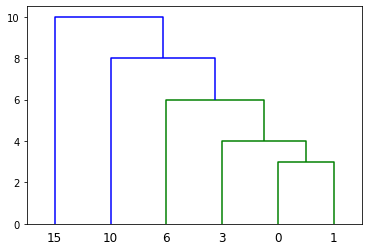

In [8]:
# Sure enough, we can use SciPy with a custom metric.
#
# Though, the final result will basically go from r=0 to infinity (until all
# clusters are merged).  But we can't peer inside to see each timestep.
from scipy.cluster.hierarchy import linkage, dendrogram


def robust_metric(a, b):
    return max(get_rk(a, data), get_rk(b, data), 1/alpha * np.sqrt((a - b)**2))

# SciPy wants an (n, d) data matrix.
linked = linkage(data[:, np.newaxis], method="single", metric=robust_metric)

dendrogram(linked, labels=data);